In [13]:
pip install numpy pandas scikit-learn


In [16]:
# Importación de bibliotecas
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos de calificaciones
ratings = pd.read_csv('ratings.csv')
# Mostrar las primeras filas de ratings
print("Primeras filas de ratings:")
print(ratings.head())

# Cargar datos de películas
movies = pd.read_csv('movies.csv')
# Mostrar las primeras filas de movies
print("\nPrimeras filas de movies:")
print(movies.head())


Primeras filas de ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Primeras filas de movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


Preprocesamiento de Datos:

Realizaremos una limpieza básica y prepararemos los datos para su uso en los modelos de recomendación.

In [17]:
# Unir datos de calificaciones y películas
data = pd.merge(ratings, movies, on='movieId')

# Crear una tabla dinámica de usuarios y películas
user_movie_matrix = data.pivot_table(index='userId', columns='title', values='rating')

# Mostrar las primeras filas de la matriz usuario-película
print("\nMatriz usuario-película:")
print(user_movie_matrix.head())



Matriz usuario-película:
title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1     

Filtrado Basado en Contenido:

Calcularemos la similitud entre películas basándonos en sus géneros.​

In [18]:
# Crear una matriz TF-IDF de los géneros
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Calcular la similitud del coseno entre las películas
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Crear un DataFrame de similitud
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])

# Mostrar una parte de la matriz de similitud
print("\nMatriz de similitud de películas (basada en géneros):")
print(cosine_sim_df.head())



Matriz de similitud de películas (basada en géneros):
title                               Toy Story (1995)  Jumanji (1995)  \
title                                                                  
Toy Story (1995)                            1.000000        0.813578   
Jumanji (1995)                              0.813578        1.000000   
Grumpier Old Men (1995)                     0.152769        0.000000   
Waiting to Exhale (1995)                    0.135135        0.000000   
Father of the Bride Part II (1995)          0.267586        0.000000   

title                               Grumpier Old Men (1995)  \
title                                                         
Toy Story (1995)                                   0.152769   
Jumanji (1995)                                     0.000000   
Grumpier Old Men (1995)                            1.000000   
Waiting to Exhale (1995)                           0.884571   
Father of the Bride Part II (1995)                 0.570915   

Filtrado Colaborativo:

Utilizaremos la descomposición en valores singulares (SVD) para predecir calificaciones faltantes.

In [19]:
# Reemplazar NaN con la media de la columna
imputer = SimpleImputer(strategy='mean')
user_movie_matrix_imputed = imputer.fit_transform(user_movie_matrix)

# Aplicar SVD
svd = TruncatedSVD(n_components=20)
matrix_svd = svd.fit_transform(user_movie_matrix_imputed)

# Mostrar la forma de la matriz SVD
print("\nForma de la matriz SVD:")
print(matrix_svd.shape)



Forma de la matriz SVD:
(610, 20)


Generación de Recomendaciones:

Crearemos funciones para obtener recomendaciones basadas en ambos métodos.

In [20]:
# Función para recomendaciones basadas en contenido
def content_based_recommendations(title, cosine_sim_df, num_recommendations=5):
    # Obtener las puntuaciones de similitud para la película dada
    sim_scores = cosine_sim_df[title].sort_values(ascending=False)
    # Excluir la película dada
    sim_scores = sim_scores.drop(title)
    # Seleccionar las películas más similares
    top_movies = sim_scores.head(num_recommendations).index
    return top_movies

# Función para recomendaciones basadas en filtrado colaborativo
def collaborative_recommendations(user_id, user_movie_matrix, matrix_svd, num_recommendations=5):
    # Obtener las calificaciones del usuario
    user_ratings = user_movie_matrix.loc[user_id].values
    # Predecir las calificaciones para todas las películas
    user_predicted_ratings = np.dot(matrix_svd[user_id - 1], svd.components_)
    # Crear un DataFrame con las calificaciones previstas
    predicted_ratings_df = pd.DataFrame(user_predicted_ratings, index=user_movie_matrix.columns, columns=['PredictedRating'])
    # Ordenar las películas por calificación prevista
    top_movies = predicted_ratings_df.sort_values(by='PredictedRating', ascending=False).head(num_recommendations).index
    return top_movies


Ejemplos de Uso y Visualización:

Mostraremos ejemplos de recomendaciones y visualizaremos los resultados.


Películas similares a 'Toy Story (1995)':
1. Shrek the Third (2007)
2. Wild, The (2006)
3. Monsters, Inc. (2001)
4. Emperor's New Groove, The (2000)
5. Antz (1998)

Recomendaciones para el usuario 1:
1. 'Salem's Lot (2004)
2. George Carlin: Back in Town (1996)
3. Alesha Popovich and Tugarin the Dragon (2004)
4. Ex Drummer (2007)
5. Advise and Consent (1962)


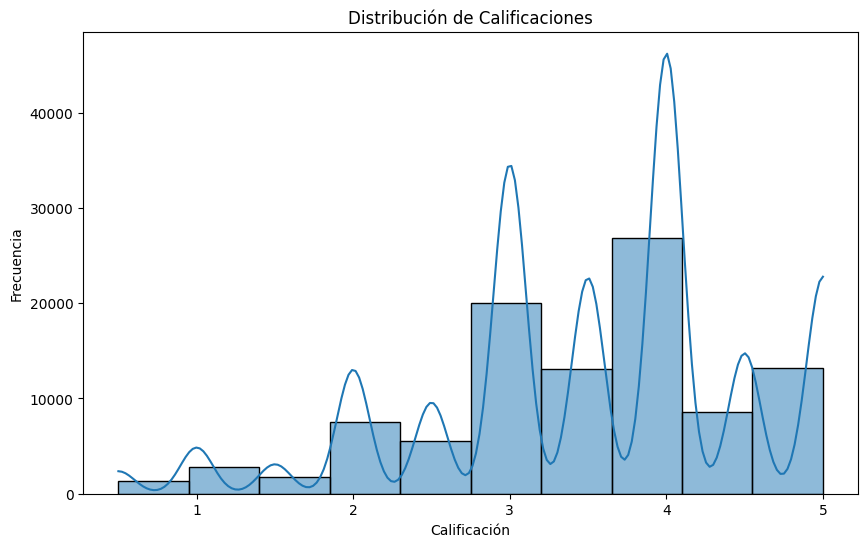

In [21]:
# Ejemplo de recomendaciones basadas en contenido
movie_title = 'Toy Story (1995)'
print(f"\nPelículas similares a '{movie_title}':")
similar_movies = content_based_recommendations(movie_title, cosine_sim_df)
for i, movie in enumerate(similar_movies, 1):
    print(f"{i}. {movie}")

# Ejemplo de recomendaciones basadas en filtrado colaborativo
user_id = 1
print(f"\nRecomendaciones para el usuario {user_id}:")
recommended_movies = collaborative_recommendations(user_id, user_movie_matrix, matrix_svd)
for i, movie in enumerate(recommended_movies, 1):
    print(f"{i}. {movie}")

# Visualización de la distribución de calificaciones
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.show()
